In [16]:
! pip install numpy

In [17]:
! pip install pyshark

In [18]:
! pip install pandas

In [19]:
! pip install matplotlib

In [20]:
! pip install seaborn

In [21]:
! sudo DEBIAN_FRONTEND=noninteractive apt install -y tshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tshark is already the newest version (3.2.3-1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [22]:
! pip install scikit-learn

In [2]:
# Imports and Configuration
import struct
import numpy as np
import pyshark
import pandas as pd
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple, List, Optional
import nest_asyncio
from collections import defaultdict, deque
import struct
from typing import List, Tuple, Optional

nest_asyncio.apply()

# Configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


In [24]:
# --- Updated ModbusSensorExtractor with EWMA & CUSUM ---
class ModbusSensorExtractor:
    def __init__(self, window_size: int = 16, ewma_alpha: float = 0.3, cusum_k_factor: float = 0.25):
        self.window_size = window_size
        self.ewma_alpha = ewma_alpha
        self.cusum_k_factor = cusum_k_factor

        self.sensor_data = defaultdict(lambda: {
            'timestamps': deque(maxlen=window_size),
            'readings': deque(maxlen=window_size),
            'sample_count': 0
        })
        self.pending_requests = {}
        self.total_readings = 0
        self.predictions_0 = 0
        self.predictions_1 = 0
        self.all_features = []
        self.feature_history = []

    # -----------------------------------------------------
    # --- Modbus parsing (same as your original code) ---
    # -----------------------------------------------------
    def parse_modbus_mbap(self, data: bytes) -> Optional[Tuple]:
        if len(data) < 7:
            return None
        return struct.unpack('>HHHB', data[:7])

    def parse_modbus_request(self, data: bytes) -> Optional[Tuple]:
        if len(data) < 5:
            return None
        return (data[0],) + struct.unpack('>HH', data[1:5])

    def parse_modbus_response(self, data: bytes) -> Optional[Tuple]:
        if len(data) < 2:
            return None
        return data[0], data[1]

    def extract_register_data(self, data: bytes, start_addr: int, num_registers: int):
        registers = []
        reg_idx = 0
        while reg_idx < num_registers:
            data_offset = 2 + (reg_idx * 2)
            if data_offset + 2 > len(data):
                break
            reg_hi = data[data_offset]
            reg_lo = data[data_offset + 1]
            regval = (reg_hi << 8) | reg_lo
            is_32bit = False
            sensor_value = 0
            actual_reg_addr = start_addr + reg_idx
            if num_registers >= 2 and reg_idx < num_registers - 1:
                next_reg_hi = data[data_offset + 2]
                next_reg_lo = data[data_offset + 3]
                next_regval = (next_reg_hi << 8) | next_reg_lo
                if regval == 0 and next_regval != 0:
                    combined_val = (regval << 16) | next_regval
                    sensor_value = np.int32(combined_val)
                    is_32bit = True
                    reg_idx += 1
                else:
                    sensor_value = np.int16(regval)
            else:
                sensor_value = np.int16(regval)
            registers.append((actual_reg_addr, sensor_value, is_32bit))
            reg_idx += 1
        return registers

    # -----------------------------------------------------
    # --- Feature helpers ---
    # -----------------------------------------------------
    def _compute_ewma(self, readings: np.ndarray) -> np.ndarray:
        """Compute EWMA series."""
        alpha = self.ewma_alpha
        ewma = np.zeros_like(readings, dtype=float)
        ewma[0] = readings[0]
        for i in range(1, len(readings)):
            ewma[i] = alpha * readings[i] + (1 - alpha) * ewma[i - 1]
        return ewma

    def _compute_cusum(self, readings: np.ndarray) -> np.ndarray:
        """Compute one-sided CUSUM for drift detection."""
        mean_ref = np.mean(readings)
        std_ref = np.std(readings)
        k = self.cusum_k_factor * (std_ref if std_ref > 0 else 1.0)
        pos_cusum = np.zeros_like(readings, dtype=float)
        s_pos = 0.0
        for i in range(1, len(readings)):
            s_pos = max(0.0, s_pos + (readings[i] - mean_ref - k))
            pos_cusum[i] = s_pos
        return pos_cusum

    def compute_slope_seconds(self, timestamps: List[float], readings: List[float]) -> float:
        n = len(readings)
        if n < 2:
            return 0.0
        t = np.array(timestamps) - timestamps[0]
        y = np.array(readings, dtype=float)
        A = np.vstack([t, np.ones(len(t))]).T
        slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(slope)

    def compute_sensor_features(self, timestamps: List[float], readings: List[float]) -> List[float]:
        """Compute raw + EWMA + CUSUM feature vector (16 values)."""
        if len(readings) != self.window_size:
            raise ValueError(f"Need exactly {self.window_size} samples, got {len(readings)}")

        readings_arr = np.array(readings, dtype=np.float32)
        timestamps_arr = np.array(timestamps)

        # --- Raw basic features (8) ---
        minv = np.min(readings_arr)
        maxv = np.max(readings_arr)
        mean = np.mean(readings_arr)
        range_val = maxv - minv

        iats = np.diff(timestamps_arr) * 1e6
        iat_min = np.min(iats) if len(iats) > 0 else 0
        iat_max = np.max(iats) if len(iats) > 0 else 0
        mean_iat = np.mean(iats) if len(iats) > 0 else 0

        slope = self.compute_slope_seconds(timestamps_arr, readings_arr)

        # --- EWMA (over readings) ---
        ewma_series = self._compute_ewma(readings_arr)
        ewma_mean = np.mean(ewma_series)
        ewma_min = np.min(ewma_series)
        ewma_max = np.max(ewma_series)
        ewma_range = ewma_max - ewma_min

        # --- CUSUM (over readings) ---
        cusum_series = self._compute_cusum(readings_arr)
        cusum_mean = np.mean(cusum_series)
        cusum_min = np.min(cusum_series)
        cusum_max = np.max(cusum_series)
        cusum_range = cusum_max - cusum_min

        features = [
            float(minv), float(maxv), float(mean),
            float(iat_min), float(iat_max), float(mean_iat),
            float(range_val), float(slope),
            float(ewma_mean), float(ewma_min), float(ewma_max), float(ewma_range),
            float(cusum_mean), float(cusum_min), float(cusum_max), float(cusum_range)
        ]
        return features

    # -----------------------------------------------------
    # --- Packet and window handling (same structure) ---
    # -----------------------------------------------------
    def process_packet(self, packet) -> List[Tuple]:
        sensor_readings = []
        try:
            timestamp = float(packet.sniff_time.timestamp())
            if not hasattr(packet, 'tcp'):
                return []
            src_port = int(packet.tcp.srcport)
            dst_port = int(packet.tcp.dstport)
            tcp_payload = bytes.fromhex(packet.tcp.payload.replace(':', ''))
            mbap = self.parse_modbus_mbap(tcp_payload)
            if not mbap:
                return []
            trans_id, protocol_id, length, unit_id = mbap
            pdu_data = tcp_payload[7:]

            # Request
            if src_port != 502 and dst_port == 502:
                if len(pdu_data) >= 5:
                    request = self.parse_modbus_request(pdu_data)
                    if request:
                        function_code, start_addr, quantity = request
                        if function_code in [0x03, 0x04]:
                            self.pending_requests[trans_id] = {
                                'unit_id': unit_id,
                                'start_addr': start_addr,
                                'num_registers': quantity,
                                'timestamp': timestamp
                            }

            # Response
            elif src_port == 502 and dst_port != 502:
                if len(pdu_data) >= 2:
                    response = self.parse_modbus_response(pdu_data)
                    if response:
                        function_code, byte_count = response
                        if function_code in [0x03, 0x04] and trans_id in self.pending_requests:
                            req = self.pending_requests[trans_id]
                            num_registers = byte_count // 2
                            registers = self.extract_register_data(pdu_data, req['start_addr'], num_registers)
                            for reg_addr, sensor_value, is_32bit in registers:
                                sensor_key = (unit_id, reg_addr)
                                sensor_readings.append((sensor_key, sensor_value, timestamp, is_32bit))
                            del self.pending_requests[trans_id]
        except Exception:
            return sensor_readings
        return sensor_readings

    def add_sensor_reading(self, sensor_key: Tuple, reading: int, timestamp: float, is_32bit: bool):
        sensor_id = self.sensor_data[sensor_key]
        self.total_readings += 1
        sensor_id['timestamps'].append(timestamp)
        sensor_id['readings'].append(reading)
        sensor_id['sample_count'] += 1

        if len(sensor_id['readings']) == self.window_size:
            features = self.compute_sensor_features(
                list(sensor_id['timestamps']), list(sensor_id['readings'])
            )
            feature_info = {
                'sensor_key': sensor_key,
                'features': features.copy(),
                'timestamp': timestamp,
                'readings': list(sensor_id['readings']),
                'timestamps': list(sensor_id['timestamps'])
            }
            self.feature_history.append(feature_info)
            sensor_id['timestamps'].clear()
            sensor_id['readings'].clear()
            sensor_id['sample_count'] = 0
            return features, sensor_key
        return None, sensor_key

    def get_statistics(self):
        return {
            'total_readings': self.total_readings,
            'unique_sensors': len(self.sensor_data),
            'feature_windows': len(self.feature_history),
            'pending_requests': len(self.pending_requests),
            'window_size': self.window_size
        }

print("✅ ModbusSensorExtractor with EWMA & CUSUM (16 features) defined!")


✅ ModbusSensorExtractor with EWMA & CUSUM (16 features) defined!


In [25]:
# Initialize and Test with Different Window Sizes
# Test different window sizes
window_sizes = [4, 8, 16, 32]
extractors = {}

for ws in window_sizes:
    extractors[ws] = ModbusSensorExtractor(window_size=ws)
    print(f"Initialized extractor with window size: {ws}")

print(f"\nAvailable extractors: {list(extractors.keys())}")

Initialized extractor with window size: 4
Initialized extractor with window size: 8
Initialized extractor with window size: 16
Initialized extractor with window size: 32

Available extractors: [4, 8, 16, 32]


In [26]:
# Process PCAP File (updated for 16 features)

def process_pcap_file(pcap_path, extractor, max_packets=1000, verbose=False):
    """Process PCAP file with given extractor (expects extractor.compute_sensor_features -> 16 features)."""
    print(f"Processing {pcap_path} with window size {extractor.window_size}...")
    
    all_features_data = []
    packet_count = 0
    features_count = 0
    cap = None
    
    try:
        # Open PCAP file (filter Modbus/TCP)
        cap = pyshark.FileCapture(pcap_path, display_filter='tcp.port == 502')
        
        for packet in cap:
            if max_packets > 0 and packet_count >= max_packets:
                break
                
            packet_count += 1
            
            # Extract sensor readings from packet
            sensor_readings = extractor.process_packet(packet)
            
            # Each sensor_reading -> (sensor_key, reading, timestamp, is_32bit)
            for sensor_key, reading, timestamp, is_32bit in sensor_readings:
                features, key = extractor.add_sensor_reading(sensor_key, reading, timestamp, is_32bit)
                
                if features is not None:
                    unit_id, reg_addr = key
                    # Insert unit/reg first, then 16 features
                    feature_row = [unit_id, reg_addr] + list(features)
                    all_features_data.append(feature_row)
                    features_count += 1
                    
                    if verbose:
                        # show a few representative fields: mean (idx 2), range (idx 6), ewma_mean (idx 8), cusum_max (idx 14)
                        mean_val = features[2] if len(features) > 2 else float('nan')
                        range_val = features[6] if len(features) > 6 else float('nan')
                        ewma_mean = features[8] if len(features) > 8 else float('nan')
                        cusum_max = features[14] if len(features) > 14 else float('nan')
                        print(f"✓ Features extracted - Sensor ({unit_id},{reg_addr}) - "
                              f"mean={mean_val:.3f} range={range_val:.3f} "
                              f"ewma_mean={ewma_mean:.3f} cusum_max={cusum_max:.3f}")
            
            if packet_count % 500 == 0 and verbose:
                print(f"Processed {packet_count} packets...")
                
    except Exception as e:
        print(f"Error reading PCAP file: {e}")
        # Ensure capture closed below
    finally:
        if cap is not None:
            try:
                cap.close()
            except Exception:
                pass
    
    # Create DataFrame with appropriate 16-feature columns
    if all_features_data:
        df = pd.DataFrame(all_features_data, columns=[
            'unit_id', 'reg_addr',
            'min', 'max', 'mean',
            'iat_min_us', 'iat_max_us', 'mean_iat_us',
            'range', 'slope',
            'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range',
            'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'
        ])
        
        print(f"\n✅ Processing Complete!")
        print(f"Packets processed: {packet_count}")
        print(f"Feature windows extracted: {features_count}")
        print(f"Unique sensors found: {len(extractor.sensor_data)}")
        
        return df
    else:
        print("❌ No features extracted - check if PCAP contains Modbus/TCP traffic")
        return None


### Exp 1: accuracy at different window sizes (4,8,16,32) for MLP with 8 features
also (MLP 16f, RF 8f and RF 16f)  

In [27]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_4 = process_pcap_file(pcap_path, extractors[4], max_packets=1000000)
print(df_normal_4.columns)
print(df_normal_4.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_4 = process_pcap_file(pcap_path, extractors[4], max_packets=1000000)
print(df_fault_4.columns)
print(df_fault_4.head())
df_normal_4.to_csv("normal_ws4.csv", index=False)
df_fault_4.to_csv("fault_ws4.csv", index=False)
# df_normal_4 = pd.read_csv("normal_ws4.csv")
# df_fault_4 = pd.read_csv("fault_ws4.csv")

Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 4...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r

KeyboardInterrupt: 

In [ ]:
df_normal = df_normal_4
df_fault = df_fault_4

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']
Class counts:
 label
1    148533
0    126810
Name: count, dtype: int64

Classification report (test):
              precision    recall  f1-score   support

           0     0.8849    0.7201    0.7941     25362
           1     0.7938    0.9201    0.8523     29707

    accuracy                         0.8280     55069
   macro avg     0.8394    0.8201    0.8232     55069
weighted avg     0.8358    0.8280    0.8255     55069

Confusion matrix:
[[18264  7098]
 [ 2375 27332]]
ROC AUC: 0.9059132324217322


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
Class counts:
 label
1    148533
0    126810
Name: count, dtype: int64

Classification report (test):
              precision    recall  f1-score   support

           0     0.8697    0.7268    0.7919     25362
           1     0.7955    0.9071    0.8476     29707

    accuracy                         0.8240     55069
   macro avg     0.8326    0.8169    0.8197     55069
weighted avg     0.8297    0.8240    0.8219     55069

Confusion matrix:
[[18433  6929]
 [ 2761 26946]]
ROC AUC: 0.90410503268514


In [ ]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_8 = process_pcap_file(pcap_path, extractors[8], max_packets=1000000)
print(df_normal_8.columns)
print(df_normal_8.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_8 = process_pcap_file(pcap_path, extractors[8], max_packets=1000000)
print(df_fault_8.columns)
print(df_fault_8.head())
df_normal_8.to_csv("normal_ws8.csv", index=False)
df_fault_8.to_csv("fault_ws8.csv", index=False)
# df_normal_8 = pd.read_csv("normal_ws8.csv")
# df_fault_8 = pd.read_csv("fault_ws8.csv")

df_normal = df_normal_8
df_fault = df_fault_8

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 8...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 63401
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max     mean    iat_min_us     iat_max_us  \
0        1        20   2266.0   3600.0   2933.0  14489.889145  202371.120453   
1        1        14      1.0      1.0      1.0  14170.169830  202106.952667   
2        1        24      0.0      0.0      0.0  14604.091644  202116.012573   
3        1        25      0.0      0.0      0.0  14604.091644  202116.012573   
4        1        22  18000.0  18000.0  18000.0  13091.087341  202329.874039   

     mean_iat_us   range         slope     ewma_mean  ewma_min      ewma_max  \
0  142815.555845  1334.0  1.323398e+03   2663.269842    2266.0   3190.7891

/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 39104 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 64464 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 74261
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr     min      max      mean   iat_min_us    iat_max_us  \
0        1        11     0.0      0.0     0.000  2753.019333  1.065050e+10   
1        1        21     0.0      0.0     0.000  2706.050873  1.066151e+10   
2        1         9  4464.0   5901.0  5541.750  2125.978470  1.065050e+10   
3        1        14     0.0     11.0     4.125  5796.194077  1.065030e+10   
4        1        20     0.0  14400.0  7200.000  5795.955658  1.065030e+10   

    mean_iat_us    range     slope     ewma_mean  ewma_min   ewma_max  \
0  1.523285e+09      0.0  0.000000      0.000000      0.00      0.000   
1  1.523187e+09     

In [ ]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_16 = process_pcap_file(pcap_path, extractors[16], max_packets=1000000)
print(df_normal_16.columns)
print(df_normal_16.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_16 = process_pcap_file(pcap_path, extractors[16], max_packets=1000000)
print(df_fault_16.columns)
print(df_fault_16.head())
df_normal_16.to_csv("normal_ws16.csv", index=False)
df_fault_16.to_csv("fault_ws16.csv", index=False)
# df_normal_16 = pd.read_csv("normal_ws16.csv")
# df_fault_16 = pd.read_csv("fault_ws16.csv")

df_normal = df_normal_16
df_fault = df_fault_16

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 16...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 31693
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max        mean    iat_min_us  \
0        1        14      1.0      1.0      1.0000  14170.169830   
1        1        20   2266.0   5333.0   3707.9375  14489.889145   
2        1        22  18000.0  18000.0  18000.0000  13091.087341   
3        1        24      0.0      0.0      0.0000  14604.091644   
4        1        25      0.0      0.0      0.0000  14604.091644   

      iat_max_us    mean_iat_us   range         slope     ewma_mean  ewma_min  \
0  208519.935608  140408.468246     0.0  1.522161e-16      1.000000       1.0   
1  203454.971313  140502.595901  3067.0  1.362937e+03   3346.694

/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 39104 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 64464 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 37134
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max        mean   iat_min_us    iat_max_us  \
0        1        11      0.0      0.0      0.0000  1802.921295  1.065050e+10   
1        1         9   4464.0   5901.0   5721.3750  2125.978470  1.065050e+10   
2        1         0      0.0  10000.0   1250.0000  2077.817917  1.065050e+10   
3        1         2  30000.0  30000.0  30000.0000  2121.925354  1.065050e+10   
4        1         4  57166.0  59606.0  57906.6875  2123.832703  1.065050e+10   

    mean_iat_us    range         slope     ewma_mean      ewma_min  \
0  7.109995e+08      0.0  0.000000e+00      0.000000      0.000000   
1  7.102

In [ ]:
pcap_path = "/home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap"
df_normal_32 = process_pcap_file(pcap_path, extractors[32], max_packets=1000000)
print(df_normal_32.columns)
print(df_normal_32.head())
pcap_path = "/home/ubuntu/raw_data/fault/faults_traffic_2025-01-10_03_22_36.pcap"
df_fault_32 = process_pcap_file(pcap_path, extractors[32], max_packets=1000000)
print(df_fault_32.columns)
print(df_fault_32.head())
df_normal_32.to_csv("normal_ws32.csv", index=False)
df_fault_32.to_csv("fault_ws32.csv", index=False)
# df_normal_32 = pd.read_csv("normal_ws32.csv")
# df_fault_32 = pd.read_csv("fault_ws32.csv")

df_normal = df_normal_32
df_fault = df_fault_32

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Processing /home/ubuntu/raw_data/normal/normal_traffic_2025-01-09_22_43_09.pcap with window size 32...


/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 48928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 33928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 15843
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max         mean   iat_min_us  \
0        1        20   2266.0   8133.0   5241.34375  8415.937424   
1        1        24      0.0      0.0      0.00000  7618.188858   
2        1        25      0.0      0.0      0.00000  7618.188858   
3        1        22  18000.0  18000.0  18000.00000  4292.011261   
4        1        14      1.0      1.0      1.00000  3010.034561   

      iat_max_us    mean_iat_us   range         slope     ewma_mean  ewma_min  \
0  207087.993622  142005.966556  5867.0  1.346000e+03   4841.143125    2266.0   
1  207062.005997  142002.928642     0.0  0.000000e+00      0.000

/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 39104 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 58928 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  sensor_value = np.int16(regval)
/tmp/ipykernel_4319/281059013.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 64464 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired r


✅ Processing Complete!
Packets processed: 1000000
Feature windows extracted: 18566
Unique sensors found: 22
Index(['unit_id', 'reg_addr', 'min', 'max', 'mean', 'iat_min_us', 'iat_max_us',
       'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
      dtype='object')
   unit_id  reg_addr      min      max       mean   iat_min_us    iat_max_us  \
0        1        11      0.0      0.0     0.0000  1802.921295  1.065050e+10   
1        1         9   4464.0   5901.0  5811.1875   152.111053  1.065050e+10   
2        1        15 -26432.0  29104.0  -742.5000  1801.013947  1.065030e+10   
3        1         1      0.0      0.0     0.0000  2077.817917  1.065150e+10   
4        1         0      0.0  10000.0  5000.0000  2077.817917  1.065050e+10   

    mean_iat_us    range     slope    ewma_mean  ewma_min     ewma_max  \
0  3.445159e+08      0.0  0.000000     0.000000      0.00     0.000000   
1  3.4

#### pull csv and test mlp / rf with all ws


In [55]:
df_normal = pd.read_csv("normal_ws32.csv")
df_fault = pd.read_csv("fault_ws32.csv")

In [56]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# --- 5) pipeline: scaler + MLP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=1000,
        random_state=42
    ))
])

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = pipe.predict(X_test)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred,digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64

Classification report (test):
              precision    recall  f1-score   support

           0     0.9347    0.6412    0.7606      3169
           1     0.7585    0.9618    0.8481      3713

    accuracy                         0.8142      6882
   macro avg     0.8466    0.8015    0.8044      6882
weighted avg     0.8396    0.8142    0.8078      6882

Confusion matrix:
[[2032 1137]
 [ 142 3571]]
ROC AUC: 0.8628783910793502


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# (a) Train and evaluate Random Forest
rf_model = RandomForestClassifier(
    max_depth=20,
    n_estimators=5,
    #max_leaf_nodes=750,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
rf_accuracy = accuracy_score(y_test, y_pred)
rf_report = classification_report(y_test, y_pred,digits=4)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# (b) Feature Importances
importances = rf_model.feature_importances_
feature_importances = (
    pd.DataFrame({'feature': numeric_cols, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("\n(b) Feature Importances")
print(feature_importances)

Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.879105
              precision    recall  f1-score   support

           0     0.9113    0.8170    0.8616      3169
           1     0.8565    0.9321    0.8927      3713

    accuracy                         0.8791      6882
   macro avg     0.8839    0.8746    0.8771      6882
weighted avg     0.8817    0.8791    0.8784      6882

Confusion matrix:
[[2589  580]
 [ 252 3461]]
ROC AUC: 0.9468319245736432

(b) Feature Importances
       feature  importance
0  mean_iat_us    0.320625
1   iat_max_us    0.251434
2   iat_min_us    0.195830
3         mean    0.073569
4          max    0.049745
5          min    0.049622
6        range    0.034729
7        slope    0.024447


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']


# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# (a) Train and evaluate Random Forest
rf_model = RandomForestClassifier(
    max_depth=20,
    n_estimators=5,
    #max_leaf_nodes=750,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
rf_accuracy = accuracy_score(y_test, y_pred)
rf_report = classification_report(y_test, y_pred,digits=4)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# (b) Feature Importances
importances = rf_model.feature_importances_
feature_importances = (
    pd.DataFrame({'feature': numeric_cols, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("\n(b) Feature Importances")
print(feature_importances)

Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.890584
              precision    recall  f1-score   support

           0     0.9281    0.8264    0.8743      3169
           1     0.8645    0.9453    0.9031      3713

    accuracy                         0.8906      6882
   macro avg     0.8963    0.8859    0.8887      6882
weighted avg     0.8938    0.8906    0.8899      6882

Confusion matrix:
[[2619  550]
 [ 203 3510]]
ROC AUC: 0.9560750748502294

(b) Feature Importances
        feature  importance
0   mean_iat_us    0.298817
1    iat_max_us    0.249205
2    iat_min_us    0.173395
3     ewma_mean    0.041253
4           max    0.038404
5           min    0.031382
6      ewma_min    0.028403
7          mean    0.02

### Exp 2: accuracy at different tree sizes and window sizesfor RF wih 8 features  

In [15]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# datasets and feature set
datasets = {
    "ws4": ("../training_features/normal_ws4.csv", "../training_features/fault_ws4.csv"),
    "ws8": ("../training_features/normal_ws8.csv", "../training_features/fault_ws8.csv"),
    "ws16": ("../training_features/normal_ws16.csv", "../training_features/fault_ws16.csv"),
    "ws32": ("../training_features/normal_ws32.csv", "../training_features/fault_ws32.csv"),
}

numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']

depths = [2, 4, 8, 16, 32]
estimators = [1, 5, 10, 25, 50]

# results container
rows = []

# ensure output dir
out_dir = "trained_models"
os.makedirs(out_dir, exist_ok=True)

for ds_name, (normal_file, fault_file) in datasets.items():
    print(f"\n=== Processing dataset: {ds_name} (files: {normal_file}, {fault_file}) ===")
    # check files exist
    if not (os.path.exists(normal_file) and os.path.exists(fault_file)):
        print(f"  SKIP: Missing file(s) for {ds_name}. Found normal: {os.path.exists(normal_file)}, fault: {os.path.exists(fault_file)}")
        continue

    # load
    df_normal = pd.read_csv(normal_file)
    df_fault  = pd.read_csv(fault_file)

    # label and combine
    df_normal = df_normal.copy(); df_fault = df_fault.copy()
    df_normal['label'] = 0
    df_fault['label']  = 1
    df = pd.concat([df_normal, df_fault], ignore_index=True)

    # drop identifier columns if present (and the extra columns you removed earlier)
    df = df.drop(columns=['unit_id', 'reg_addr',
                          'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range',
                          'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'],
                 errors='ignore')

    # ensure numeric columns
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # drop missing
    df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

    print("  Using features:", numeric_cols)
    print("  Class counts:\n", df['label'].value_counts().to_string())

    # prepare
    X = df[numeric_cols]
    y = df['label'].astype(int)

    # train/test split once per dataset (fixed)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # iterate hyperparam grid
    for max_depth in depths:
        for n_est in estimators:
            rf = RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_est,
                n_jobs=4,
                random_state=42,
                bootstrap=False
            )
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            # roc auc if possible
            roc = None
            try:
                y_prob = rf.predict_proba(X_test)[:, 1]
                roc = roc_auc_score(y_test, y_prob)
            except Exception:
                roc = np.nan

            # tree sizes
            total_nodes = 0
            for tree in rf.estimators_:
                total_nodes += tree.tree_.node_count
            avg_nodes = total_nodes / len(rf.estimators_)

            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            rows.append({
                "dataset": ds_name,
                "max_depth": max_depth,
                "n_estimators": n_est,
                "accuracy": acc,
                "roc_auc": roc,
                "avg_nodes_per_tree": avg_nodes,
                "total_nodes": total_nodes,
                "tn": int(tn),
                "fp": int(fp),
                "fn": int(fn),
                "tp": int(tp),
                "n_test_samples": len(y_test)
            })

            # --- Save the trained model to pickle ---
            model_filename = f"rf_{ds_name}_depth{max_depth}_est{n_est}.pkl"
            model_path = os.path.join(out_dir, model_filename)
            try:
                with open(model_path, "wb") as f:
                    pickle.dump(rf, f)
                print(f"  Saved model -> {model_path}")
            except Exception as e:
                print(f"  ERROR saving model {model_path}: {e}")

            print(f"  [{ds_name}] depth={max_depth:3d}, est={n_est:3d} -> acc={acc:.4f}, roc_auc={np.nan if np.isnan(roc) else f'{roc:.4f}'}, avg_nodes={avg_nodes:.1f}")

# optionally write the results summary csv
results_df = pd.DataFrame(rows)
results_df.to_csv("rf_grid_search_results.csv", index=False)
print("\nWrote rf_grid_search_results.csv")




=== Processing dataset: ws4 (files: ../training_features/normal_ws4.csv, ../training_features/fault_ws4.csv) ===
  Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
  Class counts:
 label
1    148533
0    126810
  Saved model -> trained_models/rf_ws4_depth2_est1.pkl
  [ws4] depth=  2, est=  1 -> acc=0.7884, roc_auc=0.7717, avg_nodes=7.0
  Saved model -> trained_models/rf_ws4_depth2_est5.pkl
  [ws4] depth=  2, est=  5 -> acc=0.7870, roc_auc=0.8605, avg_nodes=6.6
  Saved model -> trained_models/rf_ws4_depth2_est10.pkl
  [ws4] depth=  2, est= 10 -> acc=0.7722, roc_auc=0.8685, avg_nodes=6.4
  Saved model -> trained_models/rf_ws4_depth2_est25.pkl
  [ws4] depth=  2, est= 25 -> acc=0.7879, roc_auc=0.8705, avg_nodes=6.7
  Saved model -> trained_models/rf_ws4_depth2_est50.pkl
  [ws4] depth=  2, est= 50 -> acc=0.7604, roc_auc=0.8688, avg_nodes=6.6
  Saved model -> trained_models/rf_ws4_depth4_est1.pkl
  [ws4] depth=  4, est=  1 -> acc=0.7688, ro



=== Summary of results ===
dataset  max_depth  n_estimators  accuracy  roc_auc  avg_nodes_per_tree  total_nodes
   ws16          2             1  0.767398 0.749561                5.00          5.0
   ws16          2             5  0.788828 0.834257                5.80         29.0
   ws16          2            10  0.777568 0.865477                5.80         58.0
   ws16          2            25  0.788828 0.869623                6.12        153.0
   ws16          2            50  0.789554 0.869500                5.96        298.0
   ws16          4             1  0.811855 0.842982               17.00         17.0
   ws16          4             5  0.811129 0.870798               18.60         93.0
   ws16          4            10  0.815342 0.878323               19.40        194.0
   ws16          4            25  0.816577 0.887814               20.92        523.0
   ws16          4            50  0.819846 0.885904               20.16       1008.0
   ws16          8             1  0.

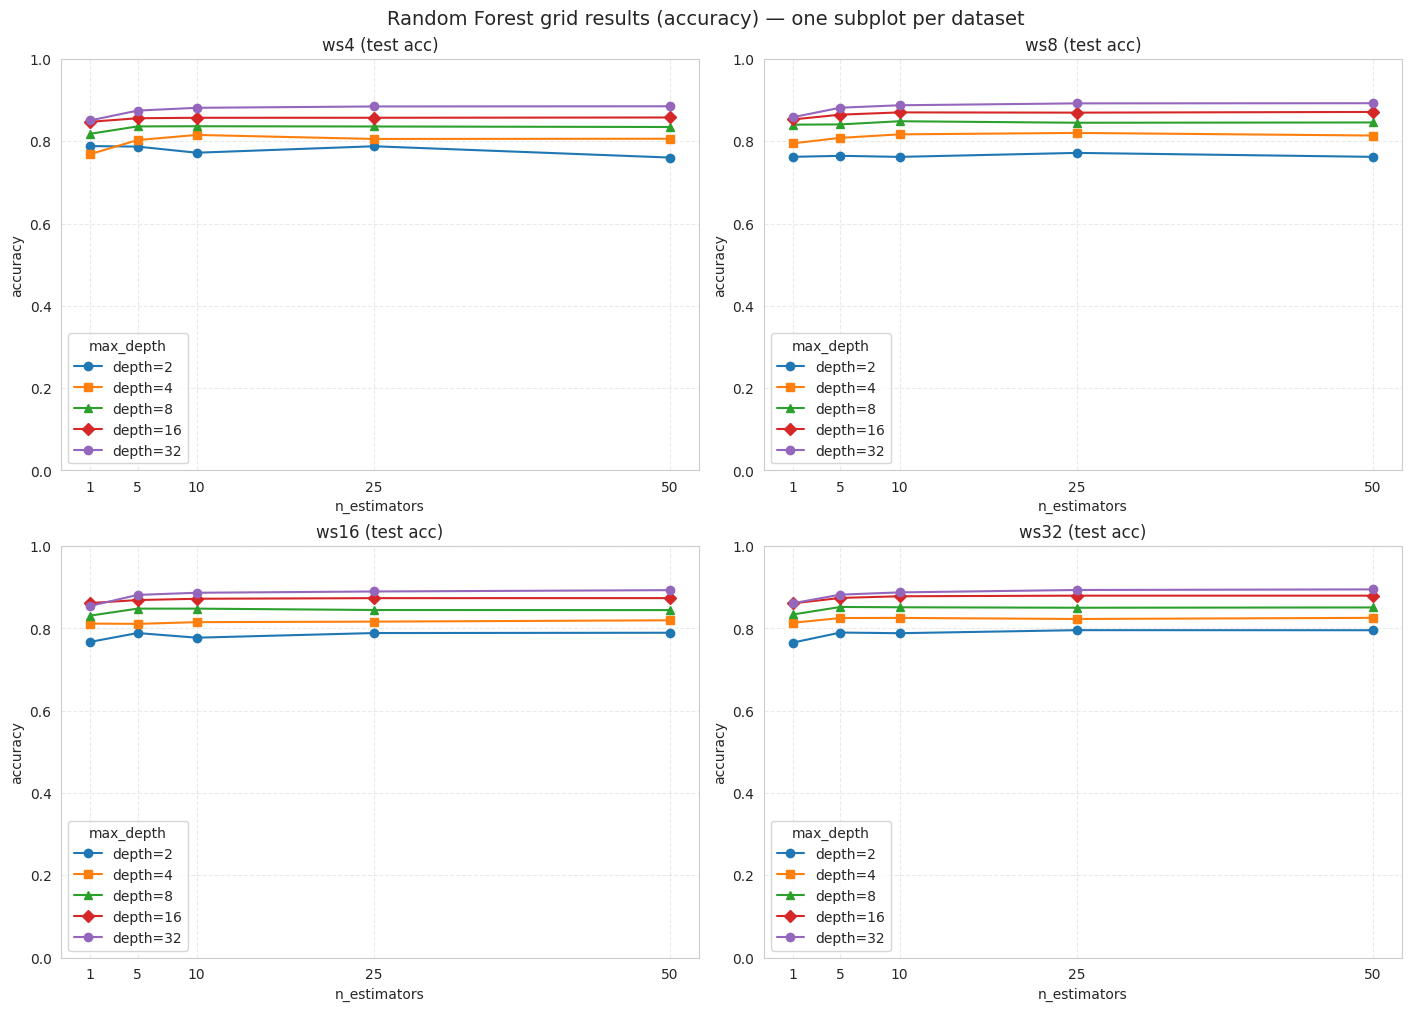

In [16]:
# results DataFrame
results_df = pd.DataFrame(rows)
if results_df.empty:
    print("\nNo completed runs (no files found). Exiting.")
else:
    # summary print
    pd.set_option('display.max_rows', None)
    print("\n\n=== Summary of results ===")
    print(results_df.groupby(['dataset','max_depth','n_estimators'])[['accuracy','roc_auc','avg_nodes_per_tree','total_nodes']].mean().reset_index().to_string(index=False))

    # Pivot for plotting: for each dataset, plot accuracy vs n_estimators with a line per depth
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    axes = axes.flatten()
    dataset_list = results_df['dataset'].unique()
    palette = ['o', 's', '^', 'D']  # markers for depths

    for ax_i, ds_name in enumerate(datasets.keys()):
        ax = axes[ax_i]
        df_ds = results_df[results_df['dataset'] == ds_name]
        if df_ds.empty:
            ax.text(0.5, 0.5, f"No data for {ds_name}", ha='center', va='center')
            ax.set_title(ds_name)
            continue

        for i, depth in enumerate(sorted(df_ds['max_depth'].unique())):
            df_line = df_ds[df_ds['max_depth'] == depth].sort_values('n_estimators')
            ax.plot(
                df_line['n_estimators'],
                df_line['accuracy'],
                marker=palette[i % len(palette)],
                label=f"depth={depth}"
            )

        ax.set_xticks(estimators)
        ax.set_ylim(0, 1.0)
        ax.set_xlabel("n_estimators")
        ax.set_ylabel("accuracy")
        ax.set_title(f"{ds_name} (test acc)")
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(title="max_depth")

    # hide any unused axes if fewer than 4 datasets ran
    for j in range(len(datasets), 4):
        if j < len(axes):
            axes[j].set_visible(False)

    out_png = "rf_grid_search_summary.png"
    plt.suptitle("Random Forest grid results (accuracy) — one subplot per dataset", fontsize=14)
    plt.savefig(out_png, dpi=150)
    print(f"\nPlot saved to: {out_png}")

    # Also print best configurations per dataset by accuracy
    print("\nBest configs per dataset (by accuracy):")
    bests = results_df.sort_values('accuracy', ascending=False).groupby('dataset').first().reset_index()
    print(bests[['dataset','max_depth','n_estimators','accuracy','roc_auc','avg_nodes_per_tree','total_nodes']].to_string(index=False))


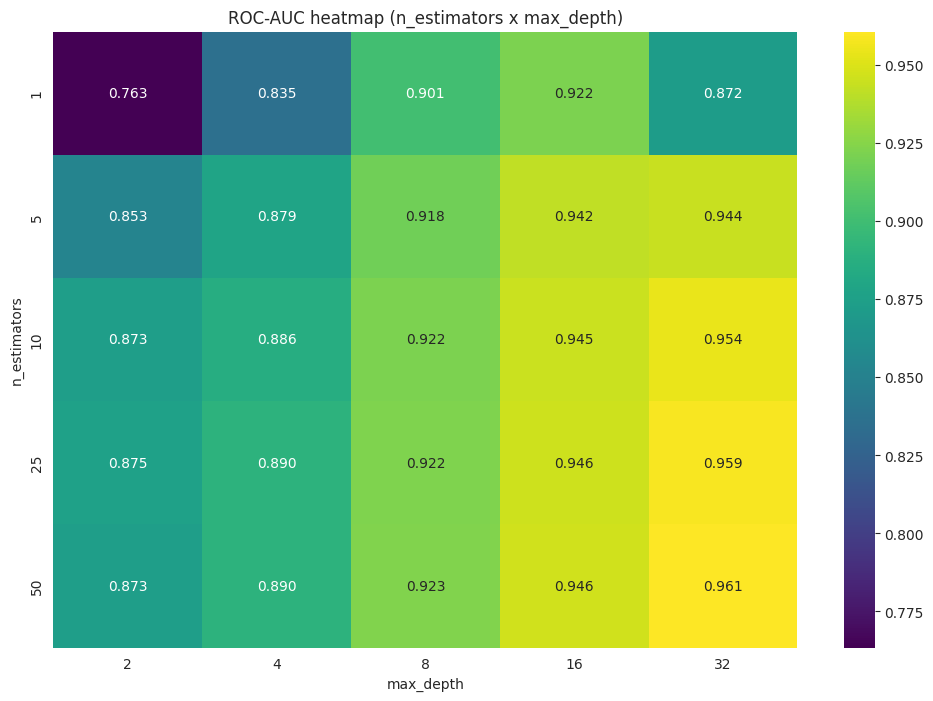

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('../training_results/exp2_tree_size/rf_grid_search_results.csv')  # your CSV
pivot = df.pivot_table(index='n_estimators', columns='max_depth', values='roc_auc', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis')
plt.title('ROC-AUC heatmap (n_estimators x max_depth)')
plt.ylabel('n_estimators'); plt.xlabel('max_depth')
plt.show()


In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RESULTS_CSV = "../training_results/exp2_tree_size/rf_grid_search_results.csv"
OUT_DIR = "plots"
os.makedirs(OUT_DIR, exist_ok=True)

def summarize_from_df(results_df):
    # Basic cleaning & types
    results_df['max_depth'] = results_df['max_depth'].replace('None', None)
    # some CSVs may have depth as string; coerce gracefully
    results_df['max_depth'] = pd.to_numeric(results_df['max_depth'], errors='coerce').astype('Int64')
    results_df['n_estimators'] = pd.to_numeric(results_df['n_estimators'], errors='coerce').astype(int)
    results_df['accuracy'] = pd.to_numeric(results_df['accuracy'], errors='coerce')
    if 'roc_auc' in results_df.columns:
        results_df['roc_auc'] = pd.to_numeric(results_df['roc_auc'], errors='coerce')

    # 1) Average accuracy per dataset
    summary = (
        results_df.groupby("dataset")["accuracy"]
        .agg(["mean", "std", "count"])
        .rename(columns={"mean": "avg_accuracy", "std": "std_accuracy", "count": "n_configs"})
        .reset_index()
    )

    # Keep dataset ordering by numeric suffix if present (ws4, ws8...)
    def extract_num(ds):
        import re
        m = re.search(r'(\d+)', ds)
        return int(m.group(1)) if m else 0
    summary['dataset_num'] = summary['dataset'].apply(extract_num)
    summary = summary.sort_values('dataset_num').reset_index(drop=True)

    print("\nAverage accuracy per dataset (sorted by dataset_num):")
    print(summary[['dataset', 'avg_accuracy', 'std_accuracy', 'n_configs']].to_string(index=False, float_format="%.6f"))

    # Bar plot with error bars (average accuracy ± std)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(summary['dataset'], summary['avg_accuracy'], yerr=summary['std_accuracy'],
           capsize=5, alpha=0.85)
    ax.set_ylabel("Average accuracy")
    ax.set_ylim(0, 1.0)
    ax.set_title("Average accuracy per dataset (with std dev)")
    for i, v in enumerate(summary['avg_accuracy']):
        ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)
    plt.tight_layout()
    barpath = os.path.join(OUT_DIR, "avg_accuracy_per_dataset.png")
    plt.savefig(barpath, dpi=200)
    print(f"Saved bar plot to {barpath}")
    plt.close(fig)

    return summary

def plot_heatmaps(results_df):
    # create a heatmap per dataset showing roc_auc (rows: n_estimators, cols: max_depth)
    if 'roc_auc' not in results_df.columns:
        print("No 'roc_auc' column found in CSV — skipping heatmaps.")
        return

    datasets = sorted(results_df['dataset'].unique(), key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
    for ds in datasets:
        df = results_df[results_df['dataset'] == ds].copy()
        # pivot: rows=n_estimators, cols=max_depth, values=roc_auc (mean if multiple)
        pivot = df.pivot_table(index='n_estimators', columns='max_depth', values='roc_auc', aggfunc='mean')
        if pivot.empty:
            print(f"Empty pivot for {ds}, skipping.")
            continue

        plt.figure(figsize=(8, 5))
        sns.heatmap(pivot, annot=True, fmt=".3f", linewidths=.5, cbar_kws={'label': 'ROC-AUC'}, cmap="viridis")
        plt.title(f"ROC-AUC heatmap — {ds} (rows=n_estimators, cols=max_depth)")
        plt.ylabel("n_estimators")
        plt.xlabel("max_depth")
        plt.tight_layout()
        heatpath = os.path.join(OUT_DIR, f"roc_auc_heatmap_{ds}.png")
        plt.savefig(heatpath, dpi=200)
        print(f"Saved heatmap for {ds} to {heatpath}")
        plt.close()

def plot_grouped_bars(results_df):
    """
    Produce grouped bar plots for each dataset:
      - accuracy (bars grouped by n_estimators, colored by max_depth)
      - roc_auc (if present)
      - avg_nodes_per_tree (log scale) vs n_estimators grouped by depth
      - fp/fn (if present)
    All plots saved to OUT_DIR.
    """
    datasets_sorted = sorted(results_df['dataset'].unique(), key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
    # Determine global sorted depths and estimators to keep consistent ordering across subplots
    global_depths = sorted(results_df['max_depth'].dropna().unique())
    global_estimators = sorted(results_df['n_estimators'].dropna().unique())

    # Helper to make grouped bar plot for a given metric
    def _grouped_bar_for_metric(metric, ylabel, filename_suffix, log_scale=False, value_fmt="{:.3f}"):
        for ds in datasets_sorted:
            df = results_df[results_df['dataset'] == ds].copy()
            if df.empty:
                print(f"No data for {ds}, skipping {metric}.")
                continue

            # prepare pivot: rows=n_estimators, cols=max_depth -> mean(metric)
            pivot = df.pivot_table(index='n_estimators', columns='max_depth', values=metric, aggfunc='mean')
            # reindex rows and columns to global ordering (fill missing with NaN)
            pivot = pivot.reindex(index=global_estimators, columns=global_depths)
            # plotting
            n_groups = len(pivot.index)
            n_depths = len(pivot.columns)
            bar_width = 0.8 / max(1, n_depths)  # keep bars within group width
            x = np.arange(n_groups)

            fig, ax = plt.subplots(figsize=(10, 5))
            for i, depth in enumerate(pivot.columns):
                vals = pivot[depth].values
                ax.bar(x + i * bar_width, vals, width=bar_width, label=f"depth={int(depth)}")

            ax.set_xticks(x + bar_width * (n_depths - 1) / 2)
            ax.set_xticklabels(pivot.index.astype(str))
            ax.set_xlabel("n_estimators")
            ax.set_ylabel(ylabel)
            ax.set_title(f"{ds} — {ylabel} by n_estimators and max_depth")
            ax.grid(True, axis='y', linestyle='--', alpha=0.4)
            ax.legend(title="max_depth", fontsize=8)
            if log_scale:
                ax.set_yscale('log')
            # annotate top of bars with values (optional: skip NaN)
            for i in range(n_groups):
                for j in range(n_depths):
                    val = pivot.iloc[i, j]
                    if pd.notna(val):
                        ax.text(x[i] + j * bar_width, val + (0 if log_scale else 0.005), value_fmt.format(val),
                                ha='center', va='bottom', fontsize=7, rotation=90 if n_depths>6 else 0)

            plt.tight_layout()
            out_path = os.path.join(OUT_DIR, f"{ds}_{filename_suffix}.png")
            plt.savefig(out_path, dpi=180)
            print(f"Saved {metric} grouped bar plot for {ds} to {out_path}")
            plt.close()

    # Accuracy bars
    _grouped_bar_for_metric(metric='accuracy', ylabel='Accuracy', filename_suffix='accuracy_grouped_bars', log_scale=False)

    # ROC-AUC bars (if present)
    if 'roc_auc' in results_df.columns:
        _grouped_bar_for_metric(metric='roc_auc', ylabel='ROC-AUC', filename_suffix='roc_auc_grouped_bars', log_scale=False)

    # avg_nodes_per_tree bars (if present) — use log scale for readability
    if 'avg_nodes_per_tree' in results_df.columns:
        _grouped_bar_for_metric(metric='avg_nodes_per_tree',
                                ylabel='avg_nodes_per_tree (log)',
                                filename_suffix='avg_nodes_grouped_bars',
                                log_scale=True,
                                value_fmt="{:.0f}")

    # total_nodes bars (if present) — log scale
    if 'total_nodes' in results_df.columns:
        _grouped_bar_for_metric(metric='total_nodes',
                                ylabel='total_nodes (log)',
                                filename_suffix='total_nodes_grouped_bars',
                                log_scale=True,
                                value_fmt="{:.0f}")

    # FP/FN grouped bars if available
    if all(c in results_df.columns for c in ['fp', 'fn']):
        # For operational view, create side-by-side fp & fn plots
        for ds in datasets_sorted:
            df = results_df[results_df['dataset'] == ds].copy()
            if df.empty:
                continue
            # pivot for fp and fn
            pivot_fp = df.pivot_table(index='n_estimators', columns='max_depth', values='fp', aggfunc='mean').reindex(index=global_estimators, columns=global_depths)
            pivot_fn = df.pivot_table(index='n_estimators', columns='max_depth', values='fn', aggfunc='mean').reindex(index=global_estimators, columns=global_depths)

            n_groups = len(global_estimators)
            n_depths = len(global_depths)
            bar_width = 0.8 / max(1, n_depths)
            x = np.arange(n_groups)

            fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
            for i, depth in enumerate(global_depths):
                axes[0].bar(x + i * bar_width, pivot_fp[depth].values, width=bar_width, label=f"d={int(depth)}")
                axes[1].bar(x + i * bar_width, pivot_fn[depth].values, width=bar_width, label=f"d={int(depth)}")

            for ax, metric_name in zip(axes, ['False Positives (fp)', 'False Negatives (fn)']):
                ax.set_xticks(x + bar_width * (n_depths - 1) / 2)
                ax.set_xticklabels([str(e) for e in global_estimators])
                ax.set_xlabel("n_estimators")
                ax.set_title(f"{ds} — {metric_name} by n_estimators and depth")
                ax.grid(True, axis='y', linestyle='--', alpha=0.4)
            axes[0].set_ylabel("count")
            axes[0].legend(title="max_depth", fontsize=8)
            out_path = os.path.join(OUT_DIR, f"{ds}_fp_fn_grouped_bars.png")
            plt.tight_layout()
            plt.savefig(out_path, dpi=180)
            print(f"Saved fp/fn grouped bars for {ds} to {out_path}")
            plt.close()

if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Results CSV not found: {RESULTS_CSV}. Place the CSV in the script directory.")

df = pd.read_csv(RESULTS_CSV)
summary = summarize_from_df(df)
plot_heatmaps(df)
plot_grouped_bars(df)



Average accuracy per dataset (sorted by dataset_num):
dataset  avg_accuracy  std_accuracy  n_configs
    ws4      0.828346      0.037578         25
    ws8      0.833598      0.043600         25
   ws16      0.838408      0.037851         25
   ws32      0.843237      0.037116         25
Saved bar plot to plots/avg_accuracy_per_dataset.png
Saved heatmap for ws4 to plots/roc_auc_heatmap_ws4.png
Saved heatmap for ws8 to plots/roc_auc_heatmap_ws8.png
Saved heatmap for ws16 to plots/roc_auc_heatmap_ws16.png
Saved heatmap for ws32 to plots/roc_auc_heatmap_ws32.png
Saved accuracy grouped bar plot for ws4 to plots/ws4_accuracy_grouped_bars.png
Saved accuracy grouped bar plot for ws8 to plots/ws8_accuracy_grouped_bars.png
Saved accuracy grouped bar plot for ws16 to plots/ws16_accuracy_grouped_bars.png
Saved accuracy grouped bar plot for ws32 to plots/ws32_accuracy_grouped_bars.png
Saved roc_auc grouped bar plot for ws4 to plots/ws4_roc_auc_grouped_bars.png
Saved roc_auc grouped bar plot for w

In [23]:
RESULTS_CSV = "../training_results/exp2_tree_size/rf_grid_search_results.csv"
TOP_N = 10  # change this to any N you want

# Load results
df = pd.read_csv(RESULTS_CSV)

# Ensure correct types
df['accuracy'] = pd.to_numeric(df['accuracy'], errors='coerce')
df['roc_auc'] = pd.to_numeric(df.get('roc_auc'), errors='coerce')
df['max_depth'] = pd.to_numeric(df['max_depth'], errors='coerce')
df['n_estimators'] = pd.to_numeric(df['n_estimators'], errors='coerce')

# Columns to display (adjust if needed)
cols = [
    'dataset',
    'max_depth',
    'n_estimators',
    'accuracy',
    'roc_auc',
    'avg_nodes_per_tree',
    'total_nodes'
]

# ---- 1) Top-N configurations overall (by accuracy) ----
top_n = (
    df.sort_values('accuracy', ascending=False)
      .head(TOP_N)
      [cols]
)

print(f"\n=== Top {TOP_N} configurations by accuracy (overall) ===")
print(top_n.to_string(index=False, float_format="%.6f"))

# ---- 2) Best configuration per dataset (by accuracy) ----
best_per_dataset = (
    df.sort_values('accuracy', ascending=False)
      .groupby('dataset', as_index=False)
      .first()
      [cols]
)

print("\n=== Best configuration per dataset (by accuracy) ===")
print(best_per_dataset.to_string(index=False, float_format="%.6f"))



=== Top 10 configurations by accuracy (overall) ===
dataset  max_depth  n_estimators  accuracy  roc_auc  avg_nodes_per_tree  total_nodes
   ws32         32            50  0.894943 0.964136         7039.280000       351964
   ws32         32            25  0.893490 0.962108         7070.120000       176753
   ws16         32            50  0.893070 0.959315        12721.080000       636054
    ws8         32            50  0.892529 0.961086        23690.240000      1184512
    ws8         32            25  0.892166 0.959542        23691.720000       592293
   ws16         32            25  0.889874 0.957258        12757.640000       318941
   ws32         32            10  0.887678 0.956541         7020.200000        70202
    ws8         32            10  0.887517 0.954483        23567.400000       235674
   ws16         32            10  0.886750 0.951118        12513.200000       125132
    ws4         32            50  0.885090 0.958229        38494.960000      1924748

=== Best co

#### Generate the test_data.h file

In [ ]:
# import numpy as np
# # ----- Use all rows of X_test -----
# n = X_test.shape[0]
# # Convert X_test to a numpy 2D array if it's a DataFrame or other structure
# if hasattr(X_test, "values"):
#     X_all = X_test.values.copy()
# else:
#     X_all = np.asarray(X_test).copy()
# # Ensure shape is (n_samples, n_features)
# if X_all.ndim != 2:
#     raise ValueError("X_test must be 2D (n_samples, n_features). Got shape: %r" % (X_all.shape,))
# # Predict expected outputs using the trained MLP
# y_pred_idx = mlp_reduced.predict(X_all)
# # Try to get string labels if a LabelEncoder 'le' is available
# try:
#     y_pred_str = le.inverse_transform(y_pred_idx)
# except Exception:
#     y_pred_str = np.array([str(int(v)) for v in y_pred_idx])
# # helper to format floats for C (single-precision literals)
# def fmt_f(x):
#     return f"{float(x):.8e}f"
# out_header = "test_data.h"
# n_features = X_all.shape[1]
# with open(out_header, "w") as f:
#     f.write("/* Auto-generated test data header: all X_test rows */\n")
#     f.write("#ifndef TEST_DATA_H\n#define TEST_DATA_H\n\n")
#     f.write("#include <stddef.h>\n\n")
#     f.write(f"/* Number of test samples and feature dimension */\n")
#     f.write(f"static const size_t TEST_N = {n}u;\n")
#     f.write(f"static const size_t TEST_F = {n_features}u;\n\n")
#     f.write(f"/* Feature array: X_test (row-major) */\n")
#     f.write(f"static const float X_test[{n}][{n_features}] = {{\n")
#     for i in range(n):
#         row = X_all[i]
#         row_vals = ", ".join(fmt_f(v) for v in row)
#         f.write(f"    {{ {row_vals} }},\n")
#     f.write("};\n\n")
#     f.write("/* Expected label indexes (as produced by mlp.predict) */\n")
#     f.write(f"static const int y_expected[{n}] = {{\n    ")
#     f.write(", ".join(str(int(v)) for v in y_pred_idx))
#     f.write("\n};\n\n")
#     f.write("/* Optional: string labels for debugging */\n")
#     f.write(f"static const char* y_expected_str[{n}] = {{\n")
#     for s in y_pred_str:
#         esc = str(s).replace("\\", "\\\\").replace('"', '\\"')
#         f.write(f'    "{esc}",\n')
#     f.write("};\n\n")
#     f.write("#endif /* TEST_DATA_H */\n")
# print(f"Header file '{out_header}' written: {n} samples x {n_features} features.")

In [6]:
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# ---------- Your data loading and preprocessing ----------
df_normal = pd.read_csv("../training_features/normal_ws8.csv")
df_fault = pd.read_csv("../training_features/fault_ws8.csv")

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr','ewma_mean', 'ewma_min', 'ewma_max',
       'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']

# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

# Quick sanity check
print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# (a) Train and evaluate Random Forest
rf_model = RandomForestClassifier(
    max_depth=32,
    n_estimators=50,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

# --- 6) train/test split and fit ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# --- 7) evaluate ---
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
rf_accuracy = accuracy_score(y_test, y_pred)
rf_report = classification_report(y_test, y_pred, digits=4)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# (b) Feature Importances
importances = rf_model.feature_importances_
feature_importances = (
    pd.DataFrame({'feature': numeric_cols, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("\n(b) Feature Importances")
print(feature_importances)

# ---------- New: write test_data.h using all X_test rows and rf predictions ----------
# Helper to format floats for C (single-precision literals)
def fmt_f(x):
    # force float conversion and format in scientific notation with 'f' suffix
    return f"{float(x):.8e}f"

# Convert X_test to numpy 2D array if it's a DataFrame or other structure
if hasattr(X_test, "values"):
    X_all = X_test.values.copy()
else:
    X_all = np.asarray(X_test).copy()

# Ensure shape is (n_samples, n_features)
if X_all.ndim != 2:
    raise ValueError("X_test must be 2D (n_samples, n_features). Got shape: %r" % (X_all.shape,))

# Number of samples and features
n = X_all.shape[0]
n_features = X_all.shape[1]

# Predict expected outputs using the trained RF
y_pred_idx = rf_model.predict(X_all)

# Try to get string labels if a LabelEncoder 'le' is available in the environment
try:
    le  # reference to check existence
    y_pred_str = le.inverse_transform(y_pred_idx)
except Exception:
    # Fall back to simple string representation of int labels
    y_pred_str = np.array([str(int(v)) for v in y_pred_idx])

out_header = "test_data.h"
OUT_DIR = "."
os.makedirs(OUT_DIR, exist_ok=True)
out_path = os.path.join(OUT_DIR, out_header)

with open(out_path, "w") as f:
    f.write("/* Auto-generated test data header: all X_test rows */\n")
    f.write("#ifndef TEST_DATA_H\n#define TEST_DATA_H\n\n")
    f.write("#include <stddef.h>\n\n")
    f.write(f"/* Number of test samples and feature dimension */\n")
    f.write(f"static const size_t TEST_N = {n}u;\n")
    f.write(f"static const size_t TEST_F = {n_features}u;\n\n")
    f.write(f"/* Feature array: X_test (row-major) */\n")
    f.write(f"static const float X_test[{n}][{n_features}] = {{\n")
    for i in range(n):
        row = X_all[i]
        row_vals = ", ".join(fmt_f(v) for v in row)
        f.write(f"    {{ {row_vals} }},\n")
    f.write("};\n\n")
    f.write("/* Expected label indexes (as produced by rf_model.predict) */\n")
    f.write(f"static const int y_expected[{n}] = {{\n    ")
    f.write(", ".join(str(int(v)) for v in y_pred_idx))
    f.write("\n};\n\n")
    f.write("/* Optional: string labels for debugging */\n")
    f.write(f"static const char* y_expected_str[{n}] = {{\n")
    for s in y_pred_str:
        esc = str(s).replace("\\", "\\\\").replace('"', '\\"')
        f.write(f'    "{esc}",\n')
    f.write("};\n\n")
    f.write("#endif /* TEST_DATA_H */\n")

print(f"Header file written to: {out_path} ({n} samples x {n_features} features).")


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
Class counts:
 label
1    74261
0    63401
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.892529
              precision    recall  f1-score   support

           0     0.9191    0.8406    0.8781     12680
           1     0.8732    0.9368    0.9039     14853

    accuracy                         0.8925     27533
   macro avg     0.8961    0.8887    0.8910     27533
weighted avg     0.8943    0.8925    0.8920     27533

Confusion matrix:
[[10659  2021]
 [  938 13915]]
ROC AUC: 0.9610856583795646

(b) Feature Importances
       feature  importance
0  mean_iat_us    0.377298
1   iat_min_us    0.211037
2   iat_max_us    0.204725
3         mean    0.059566
4          max    0.054393
5          min    0.049921
6        range    0.024813
7        slope    0.018247


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Header file written to: ./test_data.h (27533 samples x 8 features).


#### extract JSON from PKL

In [ ]:
# import pickle

# with open("trained_models/rf_best_ws16.pkl", "rb") as f:
#     rf_ws16 = pickle.load(f)

# y_pred = rf_ws16.predict(X_new)
# y_prob = rf_ws16.predict_proba(X_new)[:, 1]


In [4]:
import os
import pickle
import json
from pathlib import Path

# --- reuse your rf_to_json function (copy/paste) ---
def rf_to_json(rf_model):
    rf_data = {
        'n_estimators': len(rf_model.estimators_),
        'max_depth': rf_model.max_depth,
        'feature_importances': rf_model.feature_importances_.tolist(),
        'estimators': []
    }

    for estimator in rf_model.estimators_:
        # build per-estimator dict
        estimators_data = {
            'n_nodes': int(estimator.tree_.node_count),
            'children_left': estimator.tree_.children_left.tolist(),
            'children_right': estimator.tree_.children_right.tolist(),
            'feature': estimator.tree_.feature.tolist(),
            'threshold': estimator.tree_.threshold.tolist(),
            'class_label': [],
            'leaves': []
        }

        # Extract per-node info (leaf indicator and class label for leaves)
        # estimator.tree_.value shape: (n_nodes, 1, n_classes) in scikit-learn
        values = estimator.tree_.value  # numpy array
        classes = estimator.classes_.tolist()  # e.g. [0,1]

        for i in range(int(estimator.tree_.node_count)):
            is_leaf = int(estimator.tree_.children_left[i] == estimator.tree_.children_right[i])
            estimators_data['leaves'].append(is_leaf)

            if is_leaf:
                # value[i,0] is counts for each class at this node
                class_counts = values[i, 0]
                max_class_index = int(class_counts.argmax())
                estimators_data['class_label'].append(int(classes[max_class_index]))
            else:
                estimators_data['class_label'].append(-10)

        rf_data['estimators'].append(estimators_data)

    return rf_data

# --- main processing ---
INPUT_DIR = Path("trained_models")
OUTPUT_DIR = Path("trained_models_json")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

if not INPUT_DIR.exists():
    raise SystemExit(f"Input directory not found: {INPUT_DIR.resolve()}")

pkl_files = sorted([p for p in INPUT_DIR.iterdir() if p.suffix.lower() in ('.pkl', '.joblib')])

if not pkl_files:
    print("No .pkl or .joblib files found in", INPUT_DIR)
else:
    print(f"Found {len(pkl_files)} model files. Converting to JSON into '{OUTPUT_DIR}'...\n")

for pkl_path in pkl_files:
    try:
        print(f"Loading {pkl_path.name} ...", end=' ')
        # prefer joblib if .joblib, otherwise pickle
        with open(pkl_path, "rb") as f:
            rf_model = pickle.load(f)

        print("ok. Converting...", end=' ')
        rf_json = rf_to_json(rf_model)

        json_name = pkl_path.stem + ".json"
        out_path = OUTPUT_DIR / json_name
        with open(out_path, "w") as jf:
            json.dump(rf_json, jf, indent=2)

        print(f"saved -> {out_path.name}")
    except Exception as e:
        print(f"\nERROR processing {pkl_path.name}: {e}")
        # optionally print more detail:
        # import traceback; traceback.print_exc()
        continue

print("\nDone.")


Found 5 model files. Converting to JSON into 'trained_models_json'...

Loading rf_ws8_depth32_est1.pkl ... ok. Converting... saved -> rf_ws8_depth32_est1.json
Loading rf_ws8_depth32_est10.pkl ... ok. Converting... saved -> rf_ws8_depth32_est10.json
Loading rf_ws8_depth32_est25.pkl ... ok. Converting... saved -> rf_ws8_depth32_est25.json
Loading rf_ws8_depth32_est5.pkl ... ok. Converting... saved -> rf_ws8_depth32_est5.json
Loading rf_ws8_depth32_est50.pkl ... ok. Converting... saved -> rf_ws8_depth32_est50.json

Done.


### Exp 3: SHAP

In [6]:
! pip install shap

     |████████████████████████████████| 538 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 23.8 MB/s  eta 0:00:01
     |████████████████████████████████| 74 kB 11.7 MB/s  eta 0:00:01
     |████████████████████████████████| 3.7 MB 119.9 MB/s eta 0:00:01
     |████████████████████████████████| 43.6 MB 108.2 MB/s eta 0:00:01


In [ ]:
df_normal = pd.read_csv("normal_ws8.csv")
df_fault = pd.read_csv("fault_ws8.csv")

In [ ]:
# compute_shap_artifacts.py
import json
import joblib
import numpy as np
import pandas as pd
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# ----- 0) Your input dataframes should exist: df_normal, df_fault -----
# (They must be defined in the environment or imported before running this script.)

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr',
                'ewma_mean','ewma_min','ewma_max','ewma_range',
                'cusum_mean','cusum_min','cusum_max','cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']

# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# Train Random Forest
rf_model = RandomForestClassifier(
    max_depth=20,
    n_estimators=100,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# sklearn feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': numeric_cols, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
print("\n(b) sklearn Feature Importances")
print(feature_importances)

# -------------------------
# ---- SHAP Computation ----
# -------------------------
print("\n--- Computing SHAP values (TreeExplainer) ---")
explainer = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)

# For binary classification, take positive class (index 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_pos = shap_values[1]   # shape: (n_samples, n_features)
    expected_value = explainer.expected_value[1]
else:
    shap_pos = shap_values
    try:
        expected_value = explainer.expected_value
    except Exception:
        # fallback
        expected_value = float(np.mean(rf_model.predict_proba(X_train)[:, 1]))

# Global mean absolute SHAP
mean_abs_shap = np.mean(np.abs(shap_pos), axis=0)
shap_df = pd.DataFrame({'feature': numeric_cols, 'mean_abs_shap': mean_abs_shap})
shap_df = shap_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print("\n(c) Mean absolute SHAP values (feature ranking)")
print(shap_df)

# Save artifacts for plotting later
out_prefix = "shap_artifacts"
joblib.dump(rf_model, "model.pkl")
pd.to_pickle(X_test, "X_test.pkl")
pd.to_pickle(y_test, "y_test.pkl")
np.save("shap_pos.npy", shap_pos)
np.save("expected_value.npy", np.array([expected_value]))  # saved as array for easy load
with open("numeric_cols.json", "w") as f:
    json.dump(numeric_cols, f)
feature_importances.to_csv("feature_importances.csv", index=False)
shap_df.to_csv("shap_df.csv", index=False)

# Save a CSV with SHAP values for one example (index 0) for quick glance
example_idx = 0
sample_shap = pd.DataFrame({
    'feature': numeric_cols,
    'shap_value': shap_pos[example_idx],
    'feature_value': X_test.iloc[example_idx].values
}).sort_values('shap_value', key=lambda x: x.abs(), ascending=False)
sample_shap.to_csv(f"sample_shap_example_{example_idx}.csv", index=False)

print("\nSaved artifacts:")
print("- model.pkl")
print("- X_test.pkl")
print("- y_test.pkl")
print("- shap_pos.npy")
print("- expected_value.npy")
print("- numeric_cols.json")
print("- feature_importances.csv")
print("- shap_df.csv")
print(f"- sample_shap_example_{example_idx}.csv")

print("\nDone.")


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope', 'ewma_mean', 'ewma_min', 'ewma_max', 'ewma_range', 'cusum_mean', 'cusum_min', 'cusum_max', 'cusum_range']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.893781
              precision    recall  f1-score   support

           0     0.9329    0.8290    0.8779      3169
           1     0.8667    0.9491    0.9060      3713

    accuracy                         0.8938      6882
   macro avg     0.8998    0.8890    0.8919      6882
weighted avg     0.8972    0.8938    0.8931      6882

Confusion matrix:
[[2627  542]
 [ 189 3524]]
ROC AUC: 0.9621934208626406

(b) sklearn Feature Importances
        feature  importance
0   mean_iat_us    0.298902
1    iat_max_us    0.234662
2    iat_min_us    0.188218
3      ewma_min    0.034073
4     ewma_mean    0.030701
5           min    0.030114
6      ewma_max    0.029995
7           max

Saving SHAP summary plot to 'shap_summary.png' ...
Saving SHAP waterfall plot for test sample index 0 to 'shap_force_sample_0.png' ...


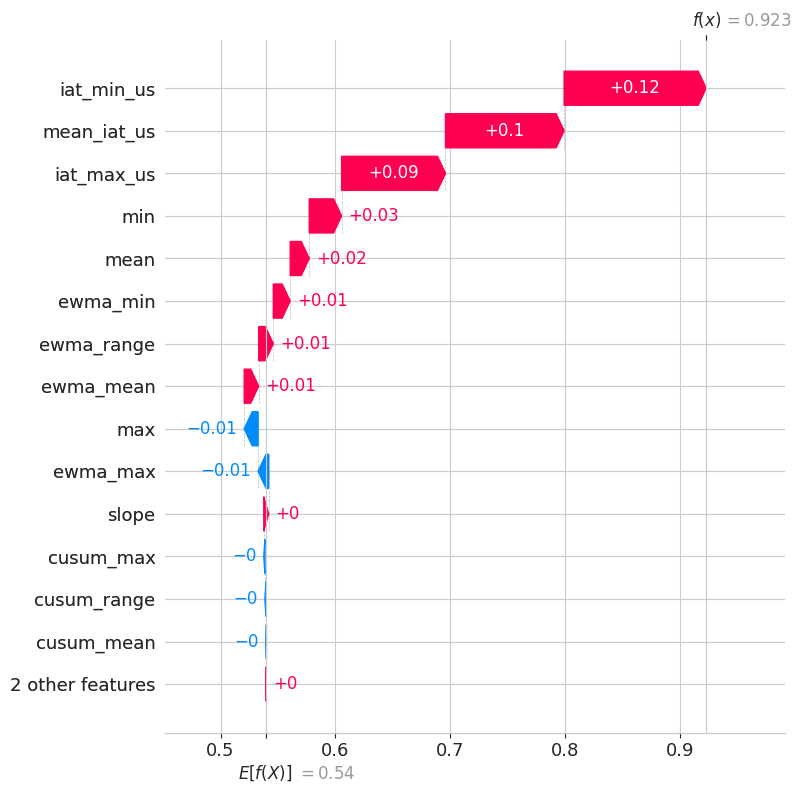

Saving SHAP dependence plot for top feature 'mean_iat_us' to 'shap_dependence_mean_iat_us.png' ...
Plots created:
- shap_summary.png
- shap_force_sample_0.png
- shap_dependence_mean_iat_us.png
Done.


<Figure size 700x500 with 0 Axes>

In [11]:
# plot_shap_artifacts.py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap

# Load artifacts
rf_model = joblib.load("model.pkl")           # not strictly required for plotting but kept for completeness
X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")
shap_pos = np.load("shap_pos.npy")            # (n_samples, n_features) for positive class
expected_value = float(np.load("expected_value.npy")[0])

with open("numeric_cols.json", "r") as f:
    numeric_cols = json.load(f)

shap_df = pd.read_csv("shap_df.csv")
feature_importances = pd.read_csv("feature_importances.csv")

# --- SHAP summary plot (global) ---
print("Saving SHAP summary plot to 'shap_summary.png' ...")
plt.figure(figsize=(8,6))
shap.summary_plot(shap_pos, X_test, feature_names=numeric_cols, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=150)
plt.close()

# --- Local explanation: waterfall / force plot for one example ---
example_idx = 0  # change as desired
print(f"Saving SHAP waterfall plot for test sample index {example_idx} to 'shap_force_sample_{example_idx}.png' ...")
plt.figure(figsize=(8,3))
# waterfall_legacy accepts expected_value, shap_values, ... 
shap.plots._waterfall.waterfall_legacy(expected_value, shap_pos[example_idx], feature_names=numeric_cols, max_display=15)
plt.tight_layout()
plt.savefig(f"shap_force_sample_{example_idx}.png", dpi=150)
plt.close()

# --- Dependence plot for top feature (from shap_df) ---
top_feature = shap_df.loc[0, 'feature']
print(f"Saving SHAP dependence plot for top feature '{top_feature}' to 'shap_dependence_{top_feature}.png' ...")
plt.figure(figsize=(7,5))
# shap.dependence_plot expects the name of the feature or column index; pass in name and use shap_pos aligned with X_test
shap.dependence_plot(top_feature, shap_pos, X_test, feature_names=numeric_cols, show=False)
plt.tight_layout()
plt.savefig(f"shap_dependence_{top_feature}.png", dpi=150)
plt.close()

print("Plots created:")
print("- shap_summary.png")
print(f"- shap_force_sample_{example_idx}.png")
print(f"- shap_dependence_{top_feature}.png")
print("Done.")


In [ ]:
# compute_shap_artifacts.py
import json
import joblib
import numpy as np
import pandas as pd
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# ----- 0) Your input dataframes should exist: df_normal, df_fault -----
# (They must be defined in the environment or imported before running this script.)

df_normal = pd.read_csv("../training_features/normal_ws32.csv")
df_fault = pd.read_csv("../training_features/fault_ws32.csv")

# --- 1) label and combine ---
df_normal = df_normal.copy()
df_fault  = df_fault.copy()
df_normal['label'] = 0
df_fault['label']  = 1
df = pd.concat([df_normal, df_fault], ignore_index=True)

# --- 2) drop identifier columns ---
df = df.drop(columns=['unit_id', 'reg_addr',
                'ewma_mean','ewma_min','ewma_max','ewma_range',
                'cusum_mean','cusum_min','cusum_max','cusum_range'], errors='ignore')

# --- 3) ensure numeric columns (from your extractor) ---
numeric_cols = ['min','max','mean','iat_min_us','iat_max_us','mean_iat_us','range','slope']

# Convert to numeric (coerce bad values -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows missing required numeric features or label
df = df.dropna(subset=numeric_cols + ['label']).reset_index(drop=True)

print("Using features:", numeric_cols)
print("Class counts:\n", df['label'].value_counts())

# --- 4) prepare X, y ---
X = df[numeric_cols]
y = df['label'].astype(int)

# Train Random Forest
rf_model = RandomForestClassifier(
    max_depth=32,
    n_estimators=50,
    n_jobs=4,
    random_state=42,
    bootstrap=False
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("(a) Model Evaluation")
print(f"Accuracy on test data: {accuracy:.6f}")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC if available
try:
    y_prob = rf_model.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# sklearn feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': numeric_cols, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
print("\n(b) sklearn Feature Importances")
print(feature_importances)

print("\nDone.")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Using features: ['min', 'max', 'mean', 'iat_min_us', 'iat_max_us', 'mean_iat_us', 'range', 'slope']
Class counts:
 label
1    18566
0    15843
Name: count, dtype: int64
(a) Model Evaluation
Accuracy on test data: 0.894943
              precision    recall  f1-score   support

           0     0.9126    0.8536    0.8821      3169
           1     0.8816    0.9302    0.9053      3713

    accuracy                         0.8949      6882
   macro avg     0.8971    0.8919    0.8937      6882
weighted avg     0.8959    0.8949    0.8946      6882

Confusion matrix:
[[2705  464]
 [ 259 3454]]
ROC AUC: 0.9641355451839235

(b) sklearn Feature Importances
       feature  importance
0  mean_iat_us    0.320551
1   iat_max_us    0.242104
2   iat_min_us    0.216451
3         mean    0.063601
4          min    0.053519
5          max    0.046213
6        slope    0.029337
7        range    0.028225

Done.


In [2]:
# -------------------------
# ---- SHAP Computation ----
# -------------------------
print("\n--- Computing SHAP values (TreeExplainer) ---")
explainer = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)

# For binary classification, take positive class (index 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_pos = shap_values[1]   # shape: (n_samples, n_features)
    expected_value = explainer.expected_value[1]
else:
    shap_pos = shap_values
    try:
        expected_value = explainer.expected_value
    except Exception:
        # fallback
        expected_value = float(np.mean(rf_model.predict_proba(X_train)[:, 1]))

# Global mean absolute SHAP
mean_abs_shap = np.mean(np.abs(shap_pos), axis=0)
shap_df = pd.DataFrame({'feature': numeric_cols, 'mean_abs_shap': mean_abs_shap})
shap_df = shap_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print("\n(c) Mean absolute SHAP values (feature ranking)")
print(shap_df)

# Save artifacts for plotting later
out_prefix = "shap_artifacts"
joblib.dump(rf_model, "model.pkl")
pd.to_pickle(X_test, "X_test.pkl")
pd.to_pickle(y_test, "y_test.pkl")
np.save("shap_pos.npy", shap_pos)
np.save("expected_value.npy", np.array([expected_value]))  # saved as array for easy load
with open("numeric_cols.json", "w") as f:
    json.dump(numeric_cols, f)
feature_importances.to_csv("feature_importances.csv", index=False)
shap_df.to_csv("shap_df.csv", index=False)

# Save a CSV with SHAP values for one example (index 0) for quick glance
example_idx = 0
sample_shap = pd.DataFrame({
    'feature': numeric_cols,
    'shap_value': shap_pos[example_idx],
    'feature_value': X_test.iloc[example_idx].values
}).sort_values('shap_value', key=lambda x: x.abs(), ascending=False)
sample_shap.to_csv(f"sample_shap_example_{example_idx}.csv", index=False)

print("\nSaved artifacts:")
print("- model.pkl")
print("- X_test.pkl")
print("- y_test.pkl")
print("- shap_pos.npy")
print("- expected_value.npy")
print("- numeric_cols.json")
print("- feature_importances.csv")
print("- shap_df.csv")
print(f"- sample_shap_example_{example_idx}.csv")


--- Computing SHAP values (TreeExplainer) ---

(c) Mean absolute SHAP values (feature ranking)
       feature  mean_abs_shap
0  mean_iat_us       0.139060
1   iat_min_us       0.101381
2   iat_max_us       0.094720
3          min       0.039228
4         mean       0.034494
5          max       0.027854
6        range       0.022891
7        slope       0.011045

Saved artifacts:
- model.pkl
- X_test.pkl
- y_test.pkl
- shap_pos.npy
- expected_value.npy
- numeric_cols.json
- feature_importances.csv
- shap_df.csv
- sample_shap_example_0.csv


Saving SHAP summary plot to 'shap_summary.png' ...
Saving SHAP waterfall plot for test sample index 0 to 'shap_force_sample_0.png' ...


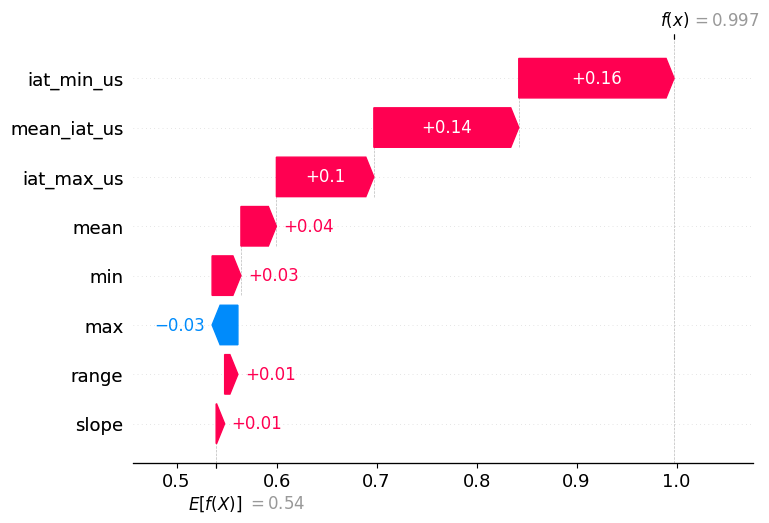

Saving SHAP dependence plot for top feature 'mean_iat_us' to 'shap_dependence_mean_iat_us.png' ...
Plots created:
- shap_summary.png
- shap_force_sample_0.png
- shap_dependence_mean_iat_us.png
Done.


<Figure size 700x500 with 0 Axes>

In [3]:
# plot_shap_artifacts.py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap

# Load artifacts
rf_model = joblib.load("model.pkl")           # not strictly required for plotting but kept for completeness
X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")
shap_pos = np.load("shap_pos.npy")            # (n_samples, n_features) for positive class
expected_value = float(np.load("expected_value.npy")[0])

with open("numeric_cols.json", "r") as f:
    numeric_cols = json.load(f)

shap_df = pd.read_csv("shap_df.csv")
feature_importances = pd.read_csv("feature_importances.csv")

# --- SHAP summary plot (global) ---
print("Saving SHAP summary plot to 'shap_summary.png' ...")
plt.figure(figsize=(8,6))
shap.summary_plot(shap_pos, X_test, feature_names=numeric_cols, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=150)
plt.close()

# --- Local explanation: waterfall / force plot for one example ---
example_idx = 0  # change as desired
print(f"Saving SHAP waterfall plot for test sample index {example_idx} to 'shap_force_sample_{example_idx}.png' ...")
plt.figure(figsize=(8,3))
# waterfall_legacy accepts expected_value, shap_values, ... 
shap.plots._waterfall.waterfall_legacy(expected_value, shap_pos[example_idx], feature_names=numeric_cols, max_display=15)
plt.tight_layout()
plt.savefig(f"shap_force_sample_{example_idx}.png", dpi=150)
plt.close()

# --- Dependence plot for top feature (from shap_df) ---
top_feature = shap_df.loc[0, 'feature']
print(f"Saving SHAP dependence plot for top feature '{top_feature}' to 'shap_dependence_{top_feature}.png' ...")
plt.figure(figsize=(7,5))
# shap.dependence_plot expects the name of the feature or column index; pass in name and use shap_pos aligned with X_test
shap.dependence_plot(top_feature, shap_pos, X_test, feature_names=numeric_cols, show=False)
plt.tight_layout()
plt.savefig(f"shap_dependence_{top_feature}.png", dpi=150)
plt.close()

print("Plots created:")
print("- shap_summary.png")
print(f"- shap_force_sample_{example_idx}.png")
print(f"- shap_dependence_{top_feature}.png")
print("Done.")
